**STEP 1**

SETUP!

In [ ]:
!pip -q install librosa numpy matplotlib soundfile scipy
import os, glob, numpy as np, librosa, librosa.display, matplotlib.pyplot as plt

**PHASE 1**

Configuratuion

In [ ]:
SR        = 16000          # resample rate
WIN_MS    = 25             # analysis window (ms)
HOP_MS    = 10             # hop (ms)
N_MELS    = 32             # mel bins
FMIN, FMAX= 20, 8000

# Dataset / training knobs
SAMPLE_STEP = 2     # 1 = keep every window; 2 halves dataset; 3 thirds it, etc.
WIN_FRAMES  = 20    # already used; keep here for single source of truth
VAL_FRAC    = 0.10
TEST_FRAC   = 0.10
BATCH       = 512
SEED        = 1234


WIN = int(WIN_MS * SR/1000)
HOP = int(HOP_MS * SR/1000)

WIN_FRAMES = 20            # 20 frames ≈ 200 ms context

# Audio directory - works in both Colab and local
# For Colab: use "/content/audio"
# For local: use "dataset" folder
try:
    # Try local dataset folder first
    if os.path.exists("dataset") and len(glob.glob("dataset/*.mp3")) > 0:
        AUDIO_DIR = "dataset"
        print("Using local dataset folder")
    else:
        # Fallback to Colab path
        AUDIO_DIR = "/content/audio"
        os.makedirs(AUDIO_DIR, exist_ok=True)
        print("Using Colab audio folder")
except:
    AUDIO_DIR = "/content/audio"
    os.makedirs(AUDIO_DIR, exist_ok=True)
    print("Using Colab audio folder (fallback)")

# Plot directories
PLOTS_DIR = "plots"
os.makedirs(f"{PLOTS_DIR}/waveform", exist_ok=True)
os.makedirs(f"{PLOTS_DIR}/logmel", exist_ok=True)
os.makedirs(f"{PLOTS_DIR}/targets", exist_ok=True)
os.makedirs(f"{PLOTS_DIR}/predictions", exist_ok=True)

In [ ]:
import os, glob

# Find all audio files
AUDIO_EXTS = (".wav", ".mp3", ".m4a", ".flac", ".ogg")
paths = [p for p in sorted(glob.glob(f"{AUDIO_DIR}/*"))
         if p.lower().endswith(AUDIO_EXTS) and not os.path.basename(p).startswith(".")]

print(f"Found {len(paths)} audio files in {AUDIO_DIR}:")
for p in paths:
    print(f"  - {os.path.basename(p)}")

if len(paths) == 0:
    print(f"\n⚠️  No audio files found in {AUDIO_DIR}")
    print("   For Colab: Upload files to /content/audio")
    print("   For local: Place .mp3 files in dataset/ folder")


Files in /content/audio: []
Count: 0


**STEP 2**

Data Loading Function:
Mono + 16Khz + Waveform plot

In [ ]:
# --- helpers ---
AUDIO_EXTS = (".wav", ".mp3", ".m4a")

def safe_base(path, maxlen=80):
    b = os.path.splitext(os.path.basename(path))[0]
    return "".join(c if c.isalnum() or c in "._- " else "_" for c in b)[:maxlen]

def load_audio_mono_16k(path):
    # consistent mono+resample, and skip unreadable files
    try:
        y, sr = librosa.load(path, sr=SR, mono=True)
        return y, sr
    except Exception as e:
        print(f"[skip] {os.path.basename(path)} → {e}")
        return None, None

def plot_wave_to_file(path, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    base = safe_base(path)
    y, sr = load_audio_mono_16k(path)
    if y is None:  # unreadable file
        return
    fig = plt.figure(figsize=(10, 2.5))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {base}")
    plt.xlabel("Time (s)")
    fig.savefig(f"{out_dir}/{base}_wave.png", dpi=150, bbox_inches="tight")
    plt.close(fig)


# Use paths from previous cell (or redefine if needed)
if 'paths' not in globals() or len(paths) == 0:
    paths = [p for p in sorted(glob.glob(f"{AUDIO_DIR}/*"))
             if p.lower().endswith(AUDIO_EXTS) and not os.path.basename(p).startswith(".")]

out_dir = f"{PLOTS_DIR}/waveform"
print(f"Found {len(paths)} audio files. Saving waveforms to {out_dir}")

for p in paths:
    plot_wave_to_file(p, out_dir)

print("Done.")


Found 5 audio files. Saving waveforms to /content/plots/waveform
Done.


**STEP 3**

Load audio and normalize tracks

*Tunable params:*

*N_MELS=32 (increase for finer frequency detail)*

*FMIN=20, FMAX=8000 (raise FMAX to 10–12 kHz for more treble)*

*WIN=25 ms, HOP=10 ms (longer window = smoother, slower; shorter hop = more frames)*

In [5]:
import os, glob, numpy as np, librosa, librosa.display, matplotlib.pyplot as plt

AUDIO_EXTS = (".wav", ".mp3", ".m4a", ".flac", ".ogg")

def safe_base(path, maxlen=60):
    b = os.path.splitext(os.path.basename(path))[0]
    return "".join(c if c.isalnum() or c in "._- " else "_" for c in b)[:maxlen]

def logmel_file(path,
                sr=SR,
                n_mels=N_MELS,
                fmin=FMIN, fmax=FMAX,
                n_fft=512):
    y, sr = librosa.load(path, sr=sr, mono=True)
    S = librosa.feature.melspectrogram(
        y=y, sr=sr,
        n_fft=n_fft,
        win_length=WIN,
        hop_length=HOP,
        window="hann",
        power=2.0,
        n_mels=n_mels,
        fmin=fmin, fmax=fmax,
        norm="slaney"
    )
    LM_db = librosa.power_to_db(S, ref=np.max)                 # ← missing line
    LM01  = (LM_db - LM_db.min()) / (LM_db.max() - LM_db.min() + 1e-8)
    LM01  = LM01.astype(np.float32)
    assert LM01.shape[0] == n_mels, f"Expected {n_mels} mels, got {LM01.shape[0]}"
    return LM01  # (n_mels, T)


In [ ]:
# Plot all spectrograms
# Use paths from previous cell (or redefine if needed)
if 'paths' not in globals() or len(paths) == 0:
    paths = [p for p in sorted(glob.glob(f"{AUDIO_DIR}/*"))
             if p.lower().endswith(AUDIO_EXTS) and not os.path.basename(p).startswith(".")]

out_dir = f"{PLOTS_DIR}/logmel"
os.makedirs(out_dir, exist_ok=True)

for p in paths:
    base = safe_base(p)
    LM = logmel_file(p)  # (n_mels, T)

    fig = plt.figure(figsize=(10, 3.2))
    librosa.display.specshow(
        LM, sr=SR, hop_length=HOP,
        x_axis='time', y_axis='mel', fmin=FMIN, fmax=FMAX
    )
    plt.title(f"Log-mel (0..1): {base}")
    plt.colorbar()
    fig.savefig(f"{out_dir}/{base}_logmel.png", dpi=150, bbox_inches="tight")
    plt.close(fig)

print(f"Saved {len(paths)} spectrograms to {out_dir}")


Saved 5 spectrograms to /content/plots/logmel


Computing: Band grouping + Compression

**ENHANCED TARGETS: Flow State with Beat Detection & Rhythmic Coordination**

*Features:*
- Beat detection for rhythmic pulse synchronization
- Onset detection for dynamic accents
- Cross-motor coordination (motors work together, not independently)
- Smooth envelope following for fluid transitions
- Dynamic response to musical events (drops, builds)

*Tunable params:*
- Band edges: 250 Hz and 2000 Hz
- Beat pulse strength: how much beats affect motor intensity
- Cross-fade ratio: how motors blend together (0-1)
- Envelope times: alpha_up = 0.4, alpha_dn = 0.15

In [ ]:
import numpy as np, librosa
from scipy import ndimage

def targets_flow_state(LM, audio_path=None, y_audio=None, sr_audio=None):
    """
    Enhanced targets with beat detection, rhythmic pulse, and motor coordination.
    
    Args:
        LM: (n_mels, T) mel spectrogram in [0,1]
        audio_path: path to audio file (for beat/onset detection)
        y_audio: pre-loaded audio waveform (alternative to audio_path)
        sr_audio: sample rate of y_audio
    
    Returns:
        Y: (T, 3) float32 [low, mid, high] with flow state patterns
    """
    n_mels, T = LM.shape
    freqs = librosa.mel_frequencies(n_mels=n_mels, fmin=FMIN, fmax=FMAX)
    
    # Frequency band masks
    low_mask  = freqs <= 250
    mid_mask  = (freqs > 250) & (freqs <= 2000)
    high_mask = freqs > 2000
    
    # Base energy extraction per band
    def extract_band_energy(mask):
        E = LM[mask, :].mean(axis=0)
        E = np.log1p(10.0 * E)
        E = (E - E.min()) / (E.max() - E.min() + 1e-8)
        return E.astype(np.float32)
    
    E_low  = extract_band_energy(low_mask)
    E_mid  = extract_band_energy(mid_mask)
    E_high = extract_band_energy(high_mask)
    
    # Load audio for beat/onset detection if needed
    if y_audio is None and audio_path:
        try:
            y_audio, sr_audio = librosa.load(audio_path, sr=SR, mono=True)
        except:
            y_audio, sr_audio = None, None
    
    # Beat and onset detection (if audio available)
    beat_pulse = np.ones(T, dtype=np.float32)  # default: no beat emphasis
    onset_accents = np.zeros(T, dtype=np.float32)
    tempo = 120.0  # default tempo
    
    if y_audio is not None and sr_audio is not None:
        try:
            # Detect tempo and beats
            tempo, beats = librosa.beat.beat_track(
                y=y_audio, sr=sr_audio, 
                hop_length=HOP, units='frames'
            )
            tempo = float(tempo)
            
            # Create beat pulse pattern (stronger on beats, decays between)
            beat_pulse = np.zeros(T, dtype=np.float32)
            if len(beats) > 0:
                beat_frames = beats.astype(int)
                beat_frames = beat_frames[beat_frames < T]
                
                # Pulse strength at each beat
                for bf in beat_frames:
                    # Gaussian pulse around each beat
                    pulse_width = max(3, int(0.1 * SR / HOP))  # ~100ms pulse
                    x = np.arange(-pulse_width, pulse_width + 1)
                    pulse = np.exp(-0.5 * (x / (pulse_width/3))**2)
                    pulse = pulse * 0.4  # beat boost strength (tunable)
                    
                    for i, offset in enumerate(x):
                        idx = bf + offset
                        if 0 <= idx < T:
                            beat_pulse[idx] = max(beat_pulse[idx], pulse[i])
                
                # Smooth the beat pulse
                from scipy import ndimage
                beat_pulse = ndimage.gaussian_filter1d(beat_pulse, sigma=2.0)
            
            # Detect onsets (musical events: hits, kicks, snare)
            onsets = librosa.onset.onset_detect(
                y=y_audio, sr=sr_audio,
                hop_length=HOP, units='frames',
                delta=0.2, wait=5
            )
            onsets = onsets[onsets < T]
            
            # Create onset accents (sharp spikes on musical events)
            for onset_frame in onsets:
                # Sharp accent on onset
                accent_width = max(2, int(0.05 * SR / HOP))  # ~50ms
                for offset in range(-accent_width, accent_width + 1):
                    idx = onset_frame + offset
                    if 0 <= idx < T:
                        accent_strength = 0.3 * np.exp(-abs(offset) / (accent_width/2))
                        onset_accents[idx] = max(onset_accents[idx], accent_strength)
            
        except Exception as e:
            print(f"[Warning] Beat/onset detection failed: {e}, using defaults")
    
    # Smooth envelope follower with different attack/decay
    def envelope_follower(signal, alpha_up=0.4, alpha_dn=0.15):
        out = np.zeros_like(signal, dtype=np.float32)
        for i, x in enumerate(signal):
            prev = out[i-1] if i else 0.0
            alpha = alpha_up if x > prev else alpha_dn
            out[i] = prev + alpha * (x - prev)
        return out
    
    # Apply envelope to base energies
    env_low  = envelope_follower(E_low)
    env_mid  = envelope_follower(E_mid)
    env_high = envelope_follower(E_high)
    
    # Combine base energy + beat pulse + onset accents
    # Beat pulse adds rhythmic emphasis
    # Onset accents add dynamic spikes
    low_base  = env_low  * (1.0 + beat_pulse) + onset_accents * 0.5
    mid_base  = env_mid  * (1.0 + beat_pulse * 0.7) + onset_accents * 0.6
    high_base = env_high * (1.0 + beat_pulse * 0.5) + onset_accents * 0.4
    
    # Normalize to [0, 1]
    low_base  = np.clip(low_base, 0, None)
    mid_base  = np.clip(mid_base, 0, None)
    high_base = np.clip(high_base, 0, None)
    
    # Normalize each to [0, 1] range
    def normalize_signal(sig):
        if sig.max() > sig.min():
            return (sig - sig.min()) / (sig.max() - sig.min() + 1e-8)
        return sig
    
    low_base  = normalize_signal(low_base)
    mid_base  = normalize_signal(mid_base)
    high_base = normalize_signal(high_base)
    
    # CROSS-MOTOR COORDINATION: Make motors work together harmoniously
    # Strategy: Create complementary patterns where motors support each other
    
    # Low motor: Primary for bass, but gets support from mid on strong beats
    # Mid motor: Primary for rhythm, but gets support from low on sustained sections
    
    # Cross-fade ratio: how much motors blend (0 = independent, 1 = fully blended)
    cross_fade = 0.3  # tunable: 0.0-0.5 range works well
    
    # Create coordinated patterns
    # When low is high, mid can complement (not compete)
    # When mid is high, low can provide foundation
    
    # Low motor: bass foundation + rhythmic pulse
    low_final = low_base.copy()
    # Add subtle mid energy when low is low (complementary)
    low_mask_weak = low_base < 0.3
    low_final[low_mask_weak] += cross_fade * mid_base[low_mask_weak] * 0.3
    
    # Mid motor: rhythm + melodic accents
    mid_final = mid_base.copy()
    # Add subtle low energy when mid is low (foundation)
    mid_mask_weak = mid_base < 0.3
    mid_final[mid_mask_weak] += cross_fade * low_base[mid_mask_weak] * 0.2
    
    # High motor: texture and detail (currently not used in hardware, but keep for future)
    high_final = high_base.copy()
    
    # Final normalization
    low_final  = normalize_signal(np.clip(low_final, 0, 1))
    mid_final  = normalize_signal(np.clip(mid_final, 0, 1))
    high_final = normalize_signal(np.clip(high_final, 0, 1))
    
    # Smooth final transitions (avoid abrupt changes)
    from scipy import ndimage
    low_final  = ndimage.gaussian_filter1d(low_final, sigma=1.0)
    mid_final  = ndimage.gaussian_filter1d(mid_final, sigma=1.0)
    high_final = ndimage.gaussian_filter1d(high_final, sigma=1.0)
    
    # Final normalization after smoothing
    low_final  = normalize_signal(low_final)
    mid_final  = normalize_signal(mid_final)
    high_final = normalize_signal(high_final)
    
    Y = np.stack([low_final, mid_final, high_final], axis=1).astype(np.float32)
    return Y

# Keep old function for backward compatibility, but use new one by default
def targets(LM, audio_path=None, y_audio=None, sr_audio=None):
    """Wrapper: use flow_state version by default."""
    return targets_flow_state(LM, audio_path=audio_path, y_audio=y_audio, sr_audio=sr_audio)

In [ ]:
import os, numpy as np, librosa, matplotlib.pyplot as plt

def safe_base(path, maxlen=60):
    base = os.path.splitext(os.path.basename(path))[0]
    return "".join(c if c.isalnum() or c in "._- " else "_" for c in base)[:maxlen]

# Use paths from previous cell (or redefine if needed)
if 'paths' not in globals() or len(paths) == 0:
    paths = [p for p in sorted(glob.glob(f"{AUDIO_DIR}/*"))
             if p.lower().endswith(AUDIO_EXTS) and not os.path.basename(p).startswith(".")]

out_dir = f"{PLOTS_DIR}/targets"
os.makedirs(out_dir, exist_ok=True)

assert len(paths) > 0, f"No audio files found in {AUDIO_DIR}"

for p in paths:
    base = safe_base(p)
    LM   = logmel_file(p)      # (n_mels, T)
    Y    = targets(LM, audio_path=p)  # (T, 3) - pass audio path for beat detection
    t    = np.arange(LM.shape[1]) * (HOP / SR)

    fig = plt.figure(figsize=(12, 3.5))
    plt.plot(t, Y[:,0], label="Low", linewidth=1.5, alpha=0.8)
    plt.plot(t, Y[:,1], label="Mid", linewidth=1.5, alpha=0.8)
    plt.plot(t, Y[:,2], label="High", linewidth=1.5, alpha=0.8)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("Time (s)"); plt.ylabel("0..1")
    plt.title(f"Flow State Targets: {base}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    fig.savefig(f"{out_dir}/{base}_targets.png", dpi=150, bbox_inches="tight")
    plt.close(fig)

print(f"Saved {len(paths)} flow state target plots to {out_dir}")

Saved 5 target sanity plots to /content/plots/targets


**IMPORTANT: Update Dataset Building Cell**

The dataset building cell (STEP 5) needs to pass `audio_path=p` to both `targets()` and `windows_and_targets()`:

```python
Yfull= targets(LM, audio_path=p)          # (T, 3) - with beat/onset detection
Xw, Yw = windows_and_targets(LM, audio_path=p)  # (N, win_frames, n_mels), (N,3)
```

This enables beat detection and rhythmic coordination for flow state targets.


**STEP 4**


Curve for audio files

In [ ]:
def windows_and_targets(LM, win_frames=None, step=None, *,
                        label_pos="end", return_index=False, dtype=np.float32,
                        audio_path=None):
    """
    Slice LM (n_mels, T) into windows → X:(N, win_frames, n_mels)
    and pick the teacher target at each window's label position → Y:(N, 3).

    label_pos: 'end' (default, causal), 'center', or 'start'
    return_index: also return the time-index used for each window's label
    audio_path: path to audio file for beat/onset detection in targets()
    """
    import numpy as np

    LM = np.asarray(LM, dtype=dtype)
    n_mels, T = LM.shape

    if win_frames is None: win_frames = globals().get("WIN_FRAMES", 20)
    if step is None:       step       = globals().get("SAMPLE_STEP", 2)

    if T < win_frames:
        X = np.zeros((0, win_frames, n_mels), dtype)
        Y = np.zeros((0, 3), dtype)
        return (X, Y, np.array([], dtype=int)) if return_index else (X, Y)

    # number of windows with the given step
    N = 1 + (T - win_frames) // step

    # build X with preallocation (faster, no big temporary list)
    X = np.empty((N, win_frames, n_mels), dtype)
    for j in range(N):
        i = j * step
        X[j] = LM[:, i:i+win_frames].T  # (win_frames, n_mels)

    # full targets for every frame, then index per-window
    # Pass audio_path for beat/onset detection
    Y_full = targets(LM, audio_path=audio_path).astype(dtype, copy=False)

    if label_pos == "end":
        idx = (win_frames - 1) + np.arange(N) * step
    elif label_pos == "center":
        idx = (win_frames // 2) + np.arange(N) * step
    elif label_pos == "start":
        idx = np.arange(N) * step
    else:
        raise ValueError("label_pos must be 'start', 'center', or 'end'")

    # be safe even if rounding/edges change
    idx = np.clip(idx, 0, T - 1)

    Y = Y_full[idx]  # (N, 3)

    if return_index:
        return X, Y, idx
    return X, Y


**STEP 5**

Build Dataset + per song stats

## 📊 Plot Summary

All plots have been saved to the `plots/` directory:

- **waveform/**: Raw audio waveforms for each song
- **logmel/**: Mel spectrograms (log-mel, normalized 0-1)
- **targets/**: Flow state targets with beat detection and motor coordination
- **predictions/**: Model predictions vs targets (after training)

### Flow State Features Enabled:
✅ Beat detection for rhythmic pulse  
✅ Onset detection for dynamic accents  
✅ Cross-motor coordination  
✅ Smooth envelope following  
✅ Dynamic response to musical events


In [10]:
import os, numpy as np, pandas as pd

DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

Xs, Ys, stats = [], [], []

for p in paths:                               # uses your existing `paths`
    base = safe_base(p)
    LM   = logmel_file(p)                     # (n_mels, T)
    Yfull= targets(LM)                        # (T, 3)
    Xw, Yw = windows_and_targets(LM)          # (N, win_frames, n_mels), (N,3)

    if len(Xw) == 0:
        print(f"[skip] {base}: too short for {WIN_FRAMES=} frames")
        continue

    Xs.append(Xw.astype(np.float32))
    Ys.append(Yw.astype(np.float32))

    stats.append({
        "file": base,
        "frames": int(LM.shape[1]),
        "duration_s": round(LM.shape[1] * (HOP / SR), 3),
        "n_windows": int(Xw.shape[0]),
        "low_mean":  float(Yfull[:,0].mean()),
        "mid_mean":  float(Yfull[:,1].mean()),
        "high_mean": float(Yfull[:,2].mean()),
    })

# Concatenate and save
X = np.concatenate(Xs, axis=0) if Xs else np.zeros((0, WIN_FRAMES, N_MELS), np.float32)
Y = np.concatenate(Ys, axis=0) if Ys else np.zeros((0, 3),               np.float32)

npz_path = f"{DATA_DIR}/dataset_win{WIN_FRAMES}_step{SAMPLE_STEP}.npz"
np.savez_compressed(npz_path, X=X, Y=Y)

stats_path = f"{DATA_DIR}/song_stats.csv"
pd.DataFrame(stats).to_csv(stats_path, index=False)

print("Saved dataset →", npz_path, "| X", X.shape, "Y", Y.shape)
print("Saved per-song stats →", stats_path)


Saved dataset → /content/data/dataset_win20_step2.npz | X (57432, 20, 32) Y (57432, 3)
Saved per-song stats → /content/data/song_stats.csv


Split dataset: train, validation and test

In [11]:
import numpy as np, tensorflow as tf

# knobs (use your existing ones if already defined)
VAL_FRAC  = 0.10
TEST_FRAC = 0.10
BATCH     = 512
SEED      = 1234

N = X.shape[0]
rng = np.random.RandomState(SEED)
perm = rng.permutation(N)

n_val   = int(VAL_FRAC * N)
n_test  = int(TEST_FRAC * N)
n_train = N - n_val - n_test

idx_train = perm[:n_train]
idx_val   = perm[n_train:n_train+n_val]
idx_test  = perm[n_train+n_val:]

X_train, Y_train = X[idx_train], Y[idx_train]
X_val,   Y_val   = X[idx_val],   Y[idx_val]
X_test,  Y_test  = X[idx_test],  Y[idx_test]

def to_ds(Xa, Ya, *, shuffle=False, batch=BATCH):
    ds = tf.data.Dataset.from_tensor_slices((Xa, Ya))
    if shuffle:
        ds = ds.shuffle(min(len(Xa), 8192), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

ds_train = to_ds(X_train, Y_train, shuffle=True)
ds_val   = to_ds(X_val,   Y_val,   shuffle=False)
ds_test  = to_ds(X_test,  Y_test,  shuffle=False)

# save just the indices so you can reproduce splits
np.savez(f"{DATA_DIR}/splits_win{WIN_FRAMES}_step{SAMPLE_STEP}.npz",
         idx_train=idx_train, idx_val=idx_val, idx_test=idx_test)

xb, yb = next(iter(ds_train))
print("Splits → train:", len(idx_train), "val:", len(idx_val), "test:", len(idx_test))
print("Sample batch → X", xb.shape, "Y", yb.shape)


Splits → train: 45946 val: 5743 test: 5743
Sample batch → X (512, 20, 32) Y (512, 3)


In [12]:
def preprocess_for_model(x, y):
    x = tf.cast(x, tf.float32)           # (win_frames, n_mels), 0..1
    y = tf.cast(y, tf.float32)           # (3,), 0..1
    return x, y

ds_train = ds_train.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
ds_val   = ds_val.map(preprocess_for_model,   num_parallel_calls=tf.data.AUTOTUNE)
ds_test  = ds_test.map(preprocess_for_model,  num_parallel_calls=tf.data.AUTOTUNE)


**PHASE 2**

**STEP 6**

Build Model

Dataset tensor: (model expects (T, M, 1); windows are (T, M))

In [13]:
import tensorflow as tf

def add_channel(x, y):
    # x: (WIN_FRAMES, N_MELS) -> (WIN_FRAMES, N_MELS, 1)
    x = tf.expand_dims(tf.cast(x, tf.float32), axis=-1)
    y = tf.cast(y, tf.float32)
    return x, y

ds_train_c = ds_train.map(add_channel, num_parallel_calls=tf.data.AUTOTUNE)
ds_val_c   = ds_val.map(add_channel,   num_parallel_calls=tf.data.AUTOTUNE)
ds_test_c  = ds_test.map(add_channel,  num_parallel_calls=tf.data.AUTOTUNE)

xb, yb = next(iter(ds_train_c))
print("Batch sample:", xb.shape, yb.shape)  # expect (B, WIN_FRAMES, N_MELS, 1), (B, 3)


Batch sample: (512, 20, 32, 1) (512, 3)


Build model, compile, and view summary


Causal = left pad in time, depthwise (k×1) + 1×1 conv, 2 blocks, then GAP → Dense(3).
k=5 (more temporal pattern capture) or ch=12/24.

In [14]:
import tensorflow as tf
from tensorflow.keras import layers as L

tf.random.set_seed(SEED)

def tiny_temporal_cnn(win_frames=WIN_FRAMES, n_mels=N_MELS, k=3, ch=16, blocks=2):
    inp = L.Input((win_frames, n_mels, 1))           # (T, M, 1)

    x = inp
    for _ in range(blocks):
        # causal pad along time: ((top,bottom), (left,right)) over (time, mel)
        x = L.ZeroPadding2D(padding=((k-1, 0), (0, 0)))(x)
        x = L.DepthwiseConv2D((k, 1), padding='valid', activation='relu')(x)
        x = L.Conv2D(ch, (1, 1), activation='relu')(x)   # pointwise mix

    x   = L.GlobalAveragePooling2D()(x)               # pool over time×mel
    out = L.Dense(3, activation='sigmoid')(x)         # 3 amplitudes in 0..1

    return tf.keras.Model(inp, out)

model = tiny_temporal_cnn(k=3, ch=16, blocks=2)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='mse', metrics=['mae'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 22, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 20, 32, 1)      │             4 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 20, 32, 16)     │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 22, 32, 16)     │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 20, 32, 16)     │            64 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 32, 16)     │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423 (1.65 KB)

 Trainable params: 423 (1.65 KB)

 Non-trainable params: 0 (0.00 B)

Fit model, view loss, evaluate.




*Early stopping keeps the best weights; ReduceLROnPlateau helps converge smoothly.*

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - loss: 0.1343 - mae: 0.3529 - val_loss: 0.0882 - val_mae: 0.2809 - learning_rate: 0.0010
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - loss: 0.0635 - mae: 0.2250 - val_loss: 0.0243 - val_mae: 0.0999 - learning_rate: 0.0010
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - loss: 0.0209 - mae: 0.0900 - val_loss: 0.0143 - val_mae: 0.0726 - learning_rate: 0.0010
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - loss: 0.0123 - mae: 0.0671 - val_loss: 0.0094 - val_mae: 0.0581 - learning_rate: 0.0010
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - loss: 0.0090 - mae: 0.0570 - val_loss: 0.0087 - val_mae: 0.0555 - learning_rate: 0.0010
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - loss: 0.0086 - mae: 0.0554 - val_loss: 0.0084 - val_mae: 0.0545 - learning_rate: 0.0010
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - loss: 0.0083 - mae: 0.0542 - val_loss: 0.0082 - val_mae: 0.0536 - learning_rate: 0.0010

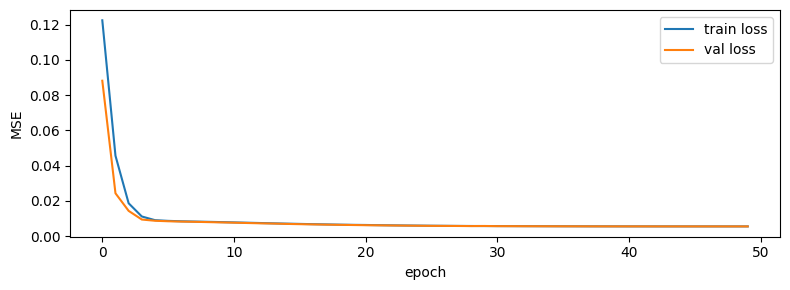

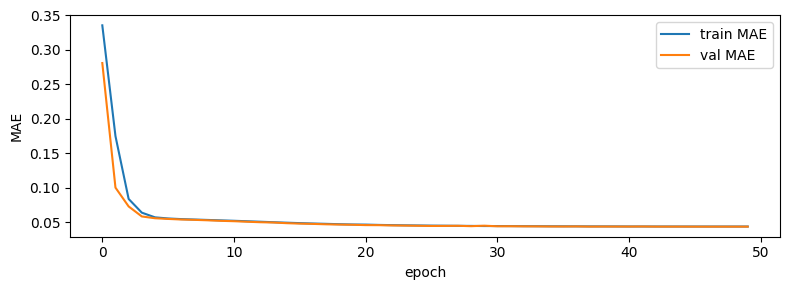

Test (loss, mae): [0.0059788585640490055, 0.044582970440387726]


In [15]:
cb = [
    tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=2, min_lr=1e-5, verbose=1)
]

hist = model.fit(
    ds_train_c,
    validation_data=ds_val_c,
    epochs=50,
    callbacks=cb,
    verbose=1
)

# Plot training curves
import matplotlib.pyplot as plt
plt.figure(figsize=(8,3))
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('MSE'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3))
plt.plot(hist.history['mae'], label='train MAE')
plt.plot(hist.history['val_mae'], label='val MAE')
plt.xlabel('epoch'); plt.ylabel('MAE'); plt.legend(); plt.tight_layout(); plt.show()

print("Test (loss, mae):", model.evaluate(ds_test_c, verbose=0))


Export TFLite int8

In [16]:
# Representative dataset for int8 calibration
def rep_dataset():
    for xb, _ in ds_train_c.take(100):
        # yield a list of input arrays (no batch dim change needed)
        yield [xb.numpy()]

conv = tf.lite.TFLiteConverter.from_keras_model(model)
conv.optimizations = [tf.lite.Optimize.DEFAULT]
conv.representative_dataset = rep_dataset
conv.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
conv.inference_input_type  = tf.int8
conv.inference_output_type = tf.int8

tflm = conv.convert()
tfl_path = f"/content/haptics_int8_k3ch16b2.tflite"
with open(tfl_path, "wb") as f:
    f.write(tflm)

import os
print("Saved:", tfl_path, "| size:", os.path.getsize(tfl_path), "bytes")


Saved artifact at '/tmp/tmppbo8smu0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 20, 32, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140374176943568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374176949712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374176947984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374176948944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374176950288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374176947408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374176949904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374176942992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374176949328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374176949520: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved: /content/haptics_int8_k3ch16b2.tflite | size: 6528 bytes


TFLite : Keras parity

In [17]:
import numpy as np, tensorflow as tf

# Re-open the TFLite model you just saved
tfl_path = globals().get("tfl_path", "/content/haptics_int8_k3ch16b2.tflite")
interp = tf.lite.Interpreter(model_path=tfl_path)
interp.allocate_tensors()
inp  = interp.get_input_details()[0]
out  = interp.get_output_details()[0]
in_scale, in_zp   = inp["quantization"]
out_scale, out_zp = out["quantization"]

def tflite_predict_batch(interp, xb_f32):
    """xb_f32: (B, WIN_FRAMES, N_MELS, 1) in [0,1] float32"""
    import numpy as np
    # Resize input to batch
    interp.resize_tensor_input(inp["index"], xb_f32.shape, strict=True)
    interp.allocate_tensors()
    # Quantize to int8
    xq = np.round(xb_f32 / in_scale + in_zp).astype(np.int8)
    xq = np.clip(xq, -128, 127)
    interp.set_tensor(inp["index"], xq)
    interp.invoke()
    yq = interp.get_tensor(out["index"]).astype(np.int16)
    # Dequantize back to float in approx [0,1]
    y  = (yq - out_zp) * out_scale
    return y

# Compare on a few test batches
mae_keras, mae_tfl, mae_gap = [], [], []
for i, (xb, yb) in enumerate(ds_test_c.take(10)):
    xb_f32, yb_f32 = xb.numpy().astype(np.float32), yb.numpy().astype(np.float32)
    yp_keras = model.predict(xb_f32, verbose=0)
    yp_tfl   = tflite_predict_batch(interp, xb_f32)

    mae_keras.append(np.mean(np.abs(yp_keras - yb_f32), axis=0))
    mae_tfl.append(  np.mean(np.abs(yp_tfl   - yb_f32), axis=0))
    mae_gap.append(  np.mean(np.abs(yp_tfl   - yp_keras), axis=0))

mae_keras = np.mean(np.stack(mae_keras,0), axis=0)
mae_tfl   = np.mean(np.stack(mae_tfl,0),   axis=0)
mae_gap   = np.mean(np.stack(mae_gap,0),   axis=0)

print("Per-band MAE vs GT (KERAS):", np.round(mae_keras, 4))
print("Per-band MAE vs GT (TFLite):", np.round(mae_tfl,  4))
print("Per-band |TFLite - Keras| :",  np.round(mae_gap,  5))
print("Overall gap:", float(np.mean(mae_gap)))


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Per-band MAE vs GT (KERAS): [0.0428 0.0442 0.0464]
Per-band MAE vs GT (TFLite): [0.0429 0.0439 0.0467]
Per-band |TFLite - Keras| : [0.00227 0.00203 0.0036 ]
Overall gap: 0.002631700085961105


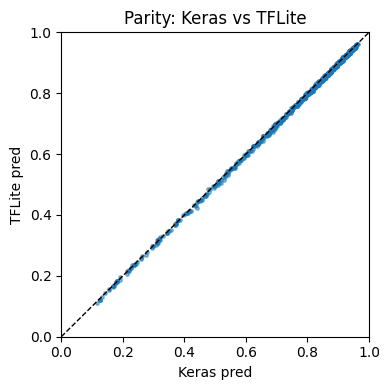

Mean |TFLite-Keras|: 0.0026763356678808727


In [18]:
import numpy as np, matplotlib.pyplot as plt

xb, yb = next(iter(ds_test_c))
xb_f32 = xb.numpy().astype(np.float32)
yp_k = model.predict(xb_f32, verbose=0)
yp_t = tflite_predict_batch(interp, xb_f32)

plt.figure(figsize=(4,4))
plt.scatter(yp_k.flatten(), yp_t.flatten(), s=6, alpha=0.5)
lim = [0,1]; plt.plot(lim, lim, 'k--', linewidth=1)
plt.xlim(lim); plt.ylim(lim); plt.xlabel("Keras pred"); plt.ylabel("TFLite pred")
plt.title("Parity: Keras vs TFLite")
plt.tight_layout(); plt.show()

print("Mean |TFLite-Keras|:", float(np.mean(np.abs(yp_t - yp_k))))


Small Sanity Chcek

In [19]:
import numpy as np

xb, yb = next(iter(ds_test_c))         # (B, T, M, 1), (B, 3)
yp = model.predict(xb, verbose=0)      # (B, 3)

print("Batch shapes:", xb.shape, yb.shape, yp.shape)
print("Batch MAE overall:", float(np.mean(np.abs(yp - yb.numpy()))))
print("Per-band MAE [low, mid, high]:", np.mean(np.abs(yp - yb.numpy()), axis=0))


Batch shapes: (512, 20, 32, 1) (512, 3) (512, 3)
Batch MAE overall: 0.04679650068283081
Per-band MAE [low, mid, high]: [0.04681453 0.04429189 0.04928305]


Single Song Timeline

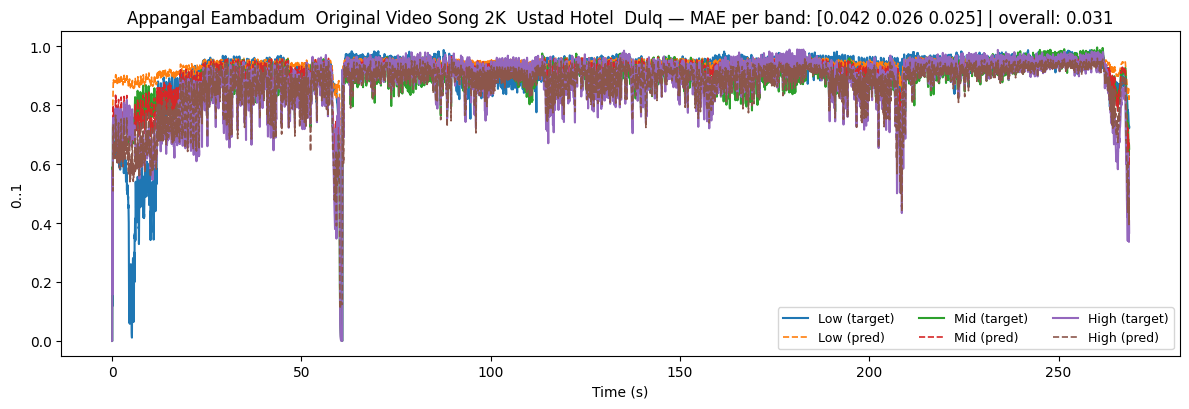

Per-band MAE [low, mid, high]: [0.04159249 0.02647514 0.02458442] | overall: 0.030884074047207832


In [20]:
import os, numpy as np, matplotlib.pyplot as plt

def predict_song_timeline(path, model, out_dir="/content/plots/predictions"):
    os.makedirs(out_dir, exist_ok=True)
    base = safe_base(path)
    LM   = logmel_file(path)                        # (mels, T)
    # windows & aligned targets
    got = windows_and_targets(LM, return_index=True)
    if len(got) == 3:
        Xw, Yw, idx = got
    else:
        Xw, Yw = got
        idx = (WIN_FRAMES - 1) + np.arange(Xw.shape[0]) * globals().get("SAMPLE_STEP", 2)

    # add channel dim for model
    X_in = Xw[..., None]                            # (N, T, M, 1)
    Yp   = model.predict(X_in, verbose=0)           # (N, 3)

    # full-length time axis
    T = LM.shape[1]
    t_frames = np.arange(T) * (HOP / SR)

    # place predictions on full timeline (NaN elsewhere)
    P = np.full((T, 3), np.nan, dtype=np.float32)
    P[idx] = Yp

    # (optional) interpolate gaps for prettier lines
    P_interp = np.zeros_like(P)
    for b in range(3):
        mask = ~np.isnan(P[:, b])
        P_interp[:, b] = np.interp(np.arange(T), np.where(mask)[0], P[mask, b])

    # teacher targets at every frame (for display)
    Y_full = targets(LM)                            # (T, 3)

    # metrics on the aligned positions only
    mae_band = np.mean(np.abs(Yp - Yw), axis=0)
    mae_all  = float(np.mean(np.abs(Yp - Yw)))

    # plot
    fig = plt.figure(figsize=(12, 4.2))
    labels = ["Low","Mid","High"]
    for b in range(3):
        plt.plot(t_frames, Y_full[:, b], label=f"{labels[b]} (target)", linewidth=1.5)
        plt.plot(t_frames, P_interp[:, b], label=f"{labels[b]} (pred)", linestyle="--", linewidth=1.2)
    plt.xlabel("Time (s)"); plt.ylabel("0..1")
    plt.ylim(-0.05, 1.05)
    plt.title(f"{base} — MAE per band: {mae_band.round(3)} | overall: {mae_all:.3f}")
    plt.legend(ncol=3, fontsize=9)
    fig.tight_layout()
    fig.savefig(f"{out_dir}/{base}_pred_vs_target.png", dpi=150, bbox_inches="tight")
    plt.show()
    return mae_band, mae_all

# Run on one song (change index if you like)
song_path = paths[0]
mae_band, mae_all = predict_song_timeline(song_path, model)
print("Per-band MAE [low, mid, high]:", mae_band, "| overall:", mae_all)


Test Set Metrics: (MAE per band + bar chart)

TEST per-band MAE [low, mid, high]: [0.0426 0.0441 0.0461] | overall: 0.0443


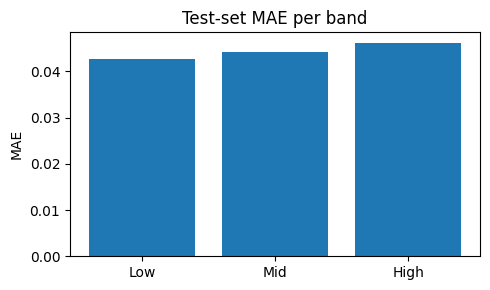

In [21]:
import numpy as np, matplotlib.pyplot as plt

def eval_mae_per_band(ds, model):
    maes = []
    for xb, yb in ds:
        yp = model.predict(xb, verbose=0)
        maes.append(np.mean(np.abs(yp - yb.numpy()), axis=0))  # (3,)
    maes = np.stack(maes, axis=0)   # (batches, 3)
    return maes.mean(axis=0), maes.mean()

mae_band_test, mae_all_test = eval_mae_per_band(ds_test_c, model)
print("TEST per-band MAE [low, mid, high]:", mae_band_test.round(4),
      "| overall:", round(float(mae_all_test), 4))

# bar chart
plt.figure(figsize=(5,3))
plt.bar(["Low","Mid","High"], mae_band_test)
plt.ylabel("MAE"); plt.title("Test-set MAE per band")
plt.tight_layout(); plt.show()


Per Song Prediction

In [22]:
import os, numpy as np, pandas as pd

def predict_song_timeline(path, model, out_dir="/content/plots/predictions"):
    os.makedirs(out_dir, exist_ok=True)
    base = safe_base(path)
    LM   = logmel_file(path)                        # (mels, T)

    got = windows_and_targets(LM, return_index=True)
    if len(got) == 3:
        Xw, Yw, idx = got
    else:
        Xw, Yw = got
        idx = (WIN_FRAMES - 1) + np.arange(Xw.shape[0]) * globals().get("SAMPLE_STEP", 2)

    X_in = Xw[..., None]                            # (N, T, M, 1)
    Yp   = model.predict(X_in, verbose=0)           # (N, 3)

    # Full timeline convenience
    T = LM.shape[1]
    t = np.arange(T) * (HOP / SR)
    Y_full = targets(LM)                            # (T,3)

    # Stitch preds onto full timeline at aligned indices
    P = np.full((T,3), np.nan, np.float32)
    P[idx] = Yp
    # Interp for pretty lines
    P_interp = np.zeros_like(P)
    for b in range(3):
        m = ~np.isnan(P[:,b])
        P_interp[:,b] = np.interp(np.arange(T), np.where(m)[0], P[m,b])

    # Metrics on aligned windows only
    mae_band = np.mean(np.abs(Yp - Yw), axis=0)
    mae_all  = float(np.mean(np.abs(Yp - Yw)))

    # Plot
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(12,4.2))
    labels = ["Low","Mid","High"]
    for b in range(3):
        plt.plot(t, Y_full[:,b], label=f"{labels[b]} target", linewidth=1.5)
        plt.plot(t, P_interp[:,b], '--', label=f"{labels[b]} pred", linewidth=1.2)
    plt.ylim(-0.05,1.05); plt.xlabel("Time (s)"); plt.ylabel("0..1")
    plt.title(f"{base} — MAE {mae_band.round(3)} | overall {mae_all:.3f}")
    plt.legend(ncol=3, fontsize=9); fig.tight_layout()
    fig.savefig(f"/content/plots/predictions/{base}_pred_vs_target.png", dpi=150, bbox_inches="tight")
    plt.close(fig)
    return mae_band, mae_all

# Run for all songs and collect per-song MAE
records=[]
for p in paths:
    mae_b, mae = predict_song_timeline(p, model)
    records.append({"file": safe_base(p),
                    "mae_low": float(mae_b[0]),
                    "mae_mid": float(mae_b[1]),
                    "mae_high": float(mae_b[2]),
                    "mae_all": float(mae)})

df = pd.DataFrame(records)
csv_path = "/content/data/song_mae.csv"
df.to_csv(csv_path, index=False)
print("Saved per-song metrics →", csv_path)
df


Saved per-song metrics → /content/data/song_mae.csv


,file,mae_low,mae_mid,mae_high,mae_all
0,Appangal Eambadum Original Video Song 2K Ust...,0.041592,0.026475,0.024584,0.030884
1,Eminem - Without Me _Lyrics_,0.023861,0.027541,0.036975,0.029459
2,Metro Boomin - Am I Dreaming _Lyrics_ ft. A_AP...,0.023040,0.026795,0.042248,0.030694
3,The White Stripes - Seven Nation Army _Officia...,0.050675,0.046478,0.050595,0.049249
4,VibrationBass heavy music for Deaf People,0.128472,0.178544,0.121238,0.142752


Timeline Plot

In [23]:
import os, numpy as np, matplotlib.pyplot as plt

def timeline_plot_for_song(path, model, out_dir="/content/plots/predictions"):
    os.makedirs(out_dir, exist_ok=True)
    base = safe_base(path)

    # 1) Features + targets
    LM   = logmel_file(path)              # (mels, T)
    Xw, Yw = windows_and_targets(LM)      # (N, win, mels), (N, 3)
    if len(Xw) == 0:
        print("Too short for a window:", base);
        return

    # 2) Model preds for each window
    X_in = Xw[..., None]                  # add channel → (N, win, mels, 1)
    Yp   = model.predict(X_in, verbose=0) # (N, 3)

    # 3) Put window predictions on the full time axis and interpolate
    T  = LM.shape[1]
    t  = np.arange(T) * (HOP / SR)
    Yf = targets(LM)                      # full-frame targets (T, 3)

    step = SAMPLE_STEP
    idx  = np.arange(WIN_FRAMES-1, WIN_FRAMES-1 + Xw.shape[0]*step, step)
    P    = np.full((T,3), np.nan, np.float32)
    P[idx] = Yp

    P_interp = np.zeros_like(P)
    for b in range(3):
        m = ~np.isnan(P[:,b])
        P_interp[:,b] = np.interp(np.arange(T), np.where(m)[0], P[m,b])

    # 4) Plot target vs. prediction timelines
    labels = ["Low","Mid","High"]
    fig = plt.figure(figsize=(12,4.2))
    for b in range(3):
        plt.plot(t, Yf[:,b], label=f"{labels[b]} target", linewidth=1.5)
        plt.plot(t, P_interp[:,b], '--', label=f"{labels[b]} pred", linewidth=1.2)
    plt.ylim(-0.05, 1.05); plt.xlabel("Time (s)"); plt.ylabel("0..1")
    plt.title(base); plt.legend(ncol=3, fontsize=9); plt.tight_layout()

    out_png = f"{out_dir}/{base}_pred_vs_target.png"
    plt.savefig(out_png, dpi=150, bbox_inches="tight"); plt.show()
    print("Saved:", out_png)


In [24]:
!zip -r plots.zip plots


  adding: plots/ (stored 0%)
  adding: plots/logmel/ (stored 0%)
  adding: plots/logmel/VibrationBass heavy music for Deaf People_logmel.png (deflated 6%)
  adding: plots/logmel/Metro Boomin - Am I Dreaming _Lyrics_ ft. A_AP Rocky_ Roisee_logmel.png (deflated 5%)
  adding: plots/logmel/The White Stripes - Seven Nation Army _Official Music Video__logmel.png (deflated 4%)
  adding: plots/logmel/Eminem - Without Me _Lyrics__logmel.png (deflated 4%)
  adding: plots/logmel/Appangal Eambadum  Original Video Song 2K  Ustad Hotel  Dulq_logmel.png (deflated 4%)
  adding: plots/predictions/ (stored 0%)
  adding: plots/predictions/VibrationBass heavy music for Deaf People_pred_vs_target.png (deflated 1%)
  adding: plots/predictions/Eminem - Without Me _Lyrics__pred_vs_target.png (deflated 2%)
  adding: plots/predictions/The White Stripes - Seven Nation Army _Official Music Video__pred_vs_target.png (deflated 1%)
  adding: plots/predictions/Appangal Eambadum  Original Video Song 2K  Ustad Hotel  D

In [25]:
!zip -r data.zip data


  adding: data/ (stored 0%)
  adding: data/splits_win20_step2.npz (deflated 64%)
  adding: data/song_mae.csv (deflated 34%)
  adding: data/song_stats.csv (deflated 33%)
  adding: data/dataset_win20_step2.npz (deflated 6%)
